### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from sklearn.preprocessing import scale, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import seaborn as sns
from datetime import datetime


The dataset `med_events.csv` is imported from [AdhereR](https://rdrr.io/cran/AdhereR/man/med.events.html)

In [3]:
tidy_df = pd.read_csv('../data/med_events.csv')
tidy_df.columns = ['pnr', 'eksd', 'perday', 'ATC', 'dur_original'] # Rename columns to remain consistency with R
tidy_df['eksd'] = pd.to_datetime(tidy_df['eksd'], format='%m/%d/%Y')

tidy_df.head()


,pnr,eksd,perday,ATC,dur_original
0,1,2033-04-26,4,medA,50
1,1,2033-07-04,4,medB,30
2,1,2033-08-03,4,medB,30
3,1,2033-08-17,4,medB,30
4,1,2033-10-13,4,medB,30


Sessa Empirical Estimator using K-Means

In [4]:
def See(arg1):
    C09CA01 = tidy_df[tidy_df['ATC'] == arg1]
    Drug_see_p0 = C09CA01.copy()
    Drug_see_p1 = C09CA01.copy()

    Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd'])
    Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
    Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
    Drug_see_p1 = Drug_see_p1.groupby('pnr').filter(lambda x: len(x) > 1).sample(frac=1).drop_duplicates('pnr')

    Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

    # Compute ECDF
    ecdf = Drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(Drug_see_p1)
    dfper = pd.DataFrame({'x': ecdf.index, 'y': ecdf.values})
    dfper = dfper[dfper['y'] <= 0.8]
    ni = dfper['x'].max()

    # Plot the 80% and 100% ECDFs
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(dfper['x'], dfper['y'], label=f'80% ECDF for {arg1}')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')
    plt.title(f'80% ECDF for {arg1}')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.scatter(ecdf.index, ecdf.values, label=f'100% ECDF for {arg1}')
    plt.xlabel('Event Interval')
    plt.ylabel('ECDF')
    plt.title(f'100% ECDF for {arg1}')
    plt.legend()
    plt.show()

    Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni]
    density = gaussian_kde(np.log(Drug_see_p2['event_interval']))
    x = np.linspace(min(np.log(Drug_see_p2['event_interval'])), max(np.log(Drug_see_p2['event_interval'])), 1000)

    plt.plot(x, density(x))
    plt.title('Log(event interval)')
    plt.show()

    a = pd.DataFrame({'x': x, 'y': density(x)})
    a = pd.DataFrame(scale(a), columns=['x', 'y'])

    # Determine the optimal number of clusters using silhouette scores
    silhouette_scores = []
    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=1234)
        kmeans.fit(a)
        score = silhouette_score(a, kmeans.labels_)
        silhouette_scores.append((n_clusters, score))
    best_n_clusters = max(silhouette_scores, key=lambda x: x[1])[0]

    n_clusters_list, scores = zip(*silhouette_scores)

    plt.figure(figsize=(8, 5))
    plt.plot(n_clusters_list, scores, marker='o', linestyle='-', label='KMeans Silhouette Score')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Scores for KMeans')
    plt.legend()
    plt.show()
    print(f'Optimal number of clusters: {best_n_clusters}')

    kmeans = KMeans(n_clusters=best_n_clusters, random_state=1234)
    kmeans.fit(dfper[['x']])
    dfper['cluster'] = kmeans.labels_

    # Fit KMeans with the optimal cluster count
    kmeans_ecdf = KMeans(n_clusters=best_n_clusters, random_state=1234, n_init=10)
    dfper['ecdf_cluster'] = kmeans_ecdf.fit_predict(dfper[['x', 'y']])

    # Plot ECDF Clusters
    plt.figure(figsize=(8, 5))
    for cluster in range(best_n_clusters):
        cluster_data = dfper[dfper['ecdf_cluster'] == cluster]
        plt.scatter(cluster_data['x'], cluster_data['y'], label=f'Cluster {cluster}')
        
    plt.xlabel('x (event interval)')
    plt.ylabel('y (ECDF)')
    plt.title(f'ECDF Clustering for {arg1}')
    plt.legend()
    plt.show()

    cluster_summary = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()
    cluster_summary.columns = ['cluster', 'min', 'max', 'median']

    Drug_see_p1['event_interval'] = Drug_see_p1['event_interval'].astype(float)
    results = Drug_see_p1.merge(cluster_summary, left_on='event_interval', right_on='median', how='left')
    results['cluster'] = results['cluster'].fillna(0).astype(int)
    results['Median'] = results['median'].apply(np.exp)
    results = results[['pnr', 'Median', 'cluster']]
    
    t1 = results['cluster'].value_counts().idxmax()
    t1_merged = results[results['cluster'] == t1].iloc[0]

    Drug_see_p1 = Drug_see_p1.merge(results, on='pnr', how='left')
    Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1_merged['Median'])
    Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0).astype(int)
    Drug_see_p1['test'] = (Drug_see_p1['event_interval'] - Drug_see_p1['Median']).round(1)
    
    Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']]
    Drug_see_p0 = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
    Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1_merged['Median'])
    Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0).astype(int)
    
    return Drug_see_p0


In [5]:
def see_assumption(arg1, label):
    arg1 = arg1.sort_values(by=['pnr', 'eksd'])
    arg1['prev_eksd'] = arg1.groupby('pnr')['eksd'].shift(1)
    
    Drug_see2 = arg1.dropna(subset=['prev_eksd']).copy()
    Drug_see2['p_number'] = Drug_see2.groupby('pnr').cumcount() + 1
    Drug_see2 = Drug_see2[Drug_see2['p_number'] >= 2]
    Drug_see2['Duration'] = (Drug_see2['eksd'] - Drug_see2['prev_eksd']).dt.days
    
    medians_of_medians = Drug_see2.groupby('pnr')['Duration'].median().median()

    plt.figure(figsize=(10, 6))
    sns.boxplot(x='p_number', y='Duration', data=Drug_see2)
    plt.axhline(medians_of_medians, color='red', linestyle='--')
    plt.title(f'Duration by Prescription Number with Median Line for {label}')
    plt.show()

    return plt

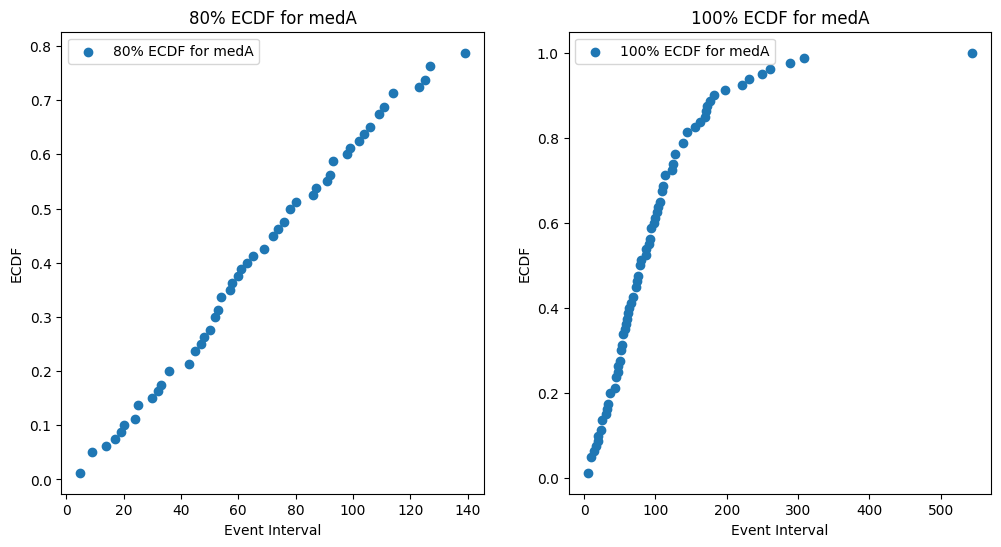

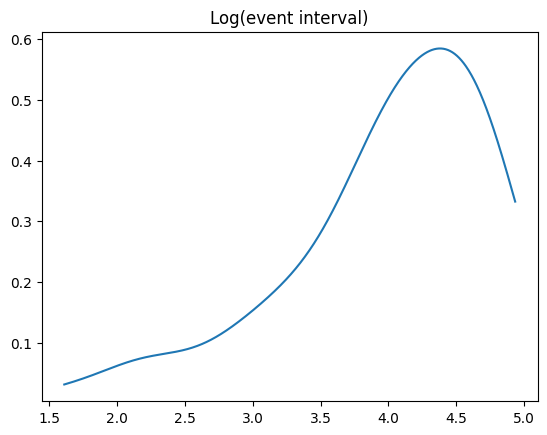

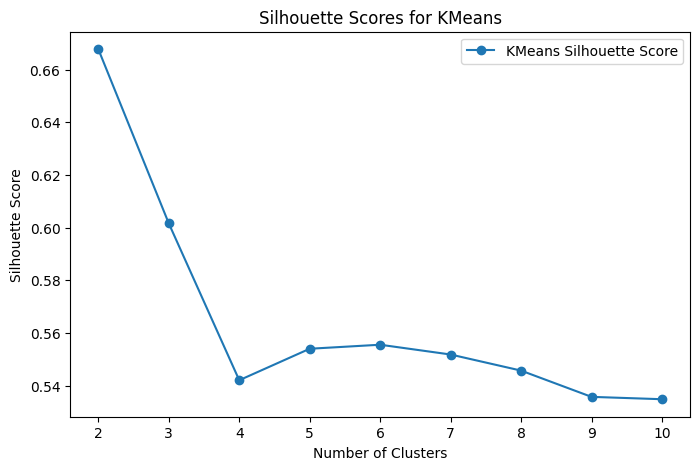

Optimal number of clusters: 2


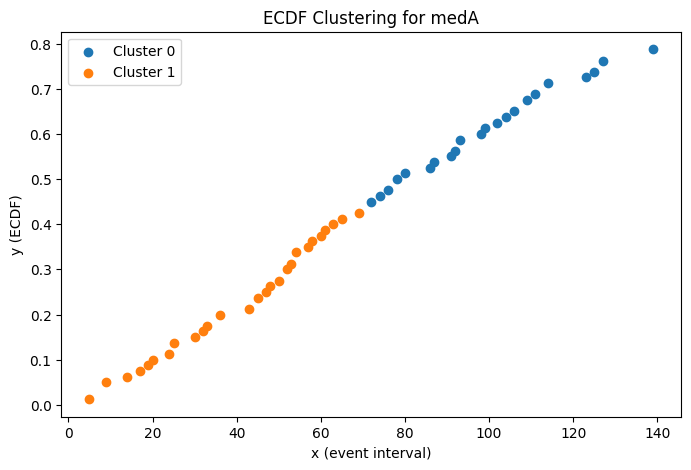

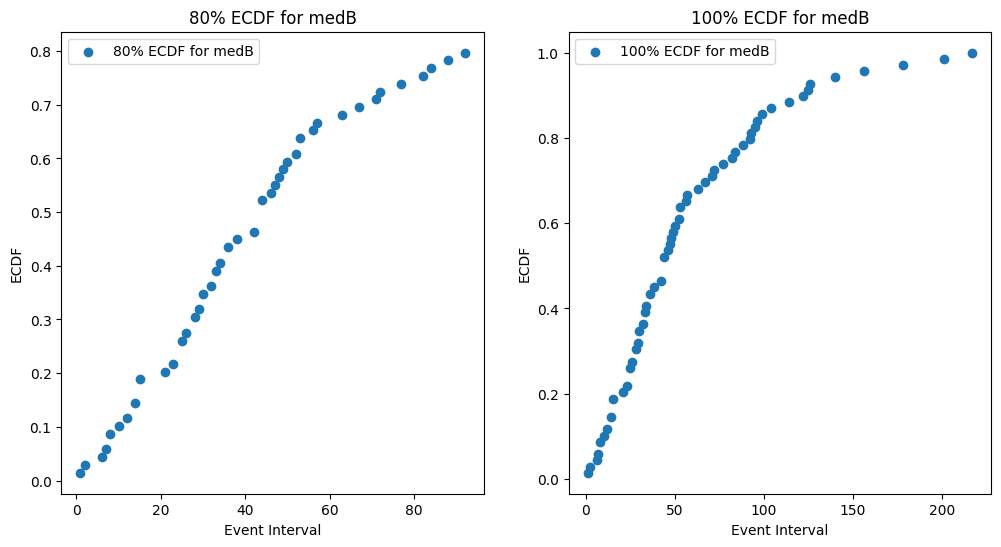

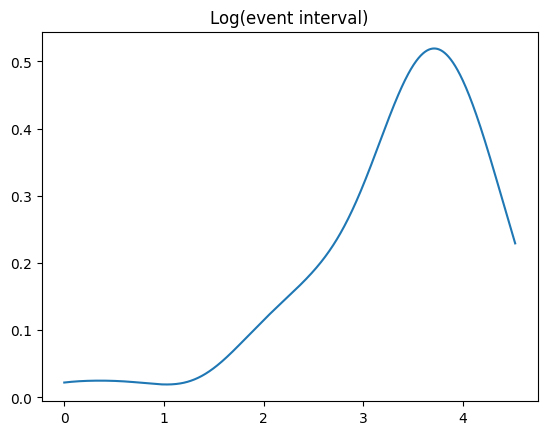

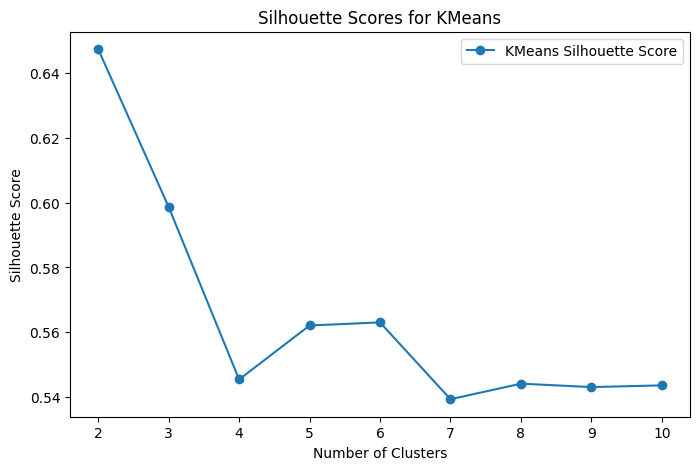

Optimal number of clusters: 2


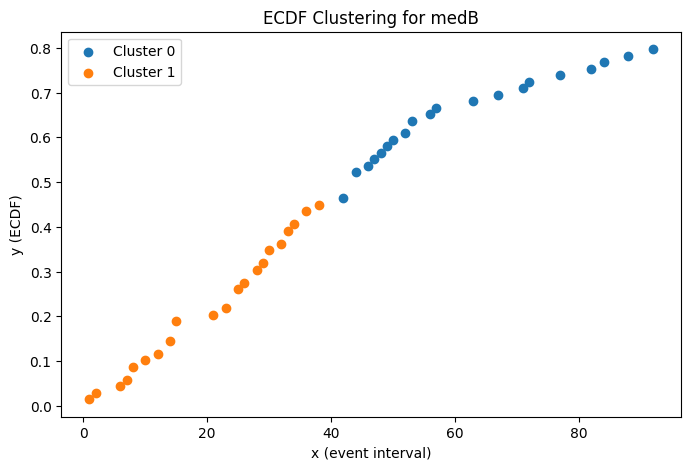

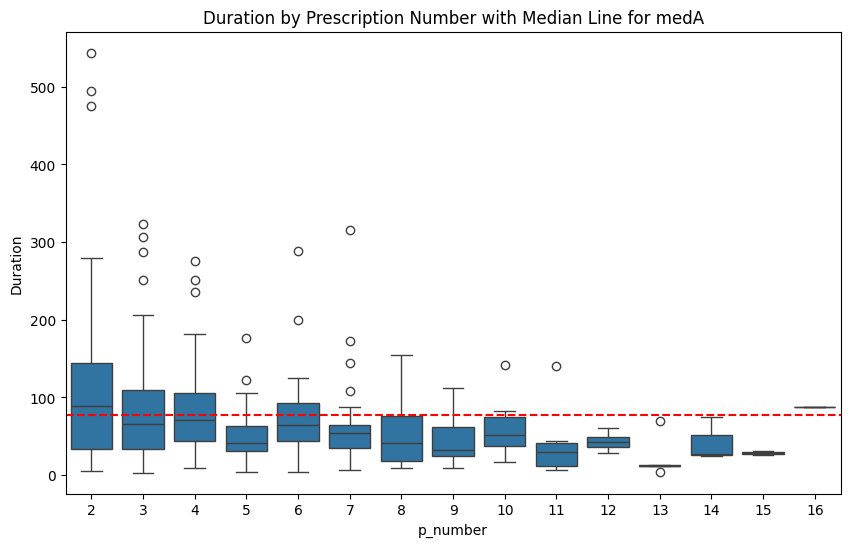

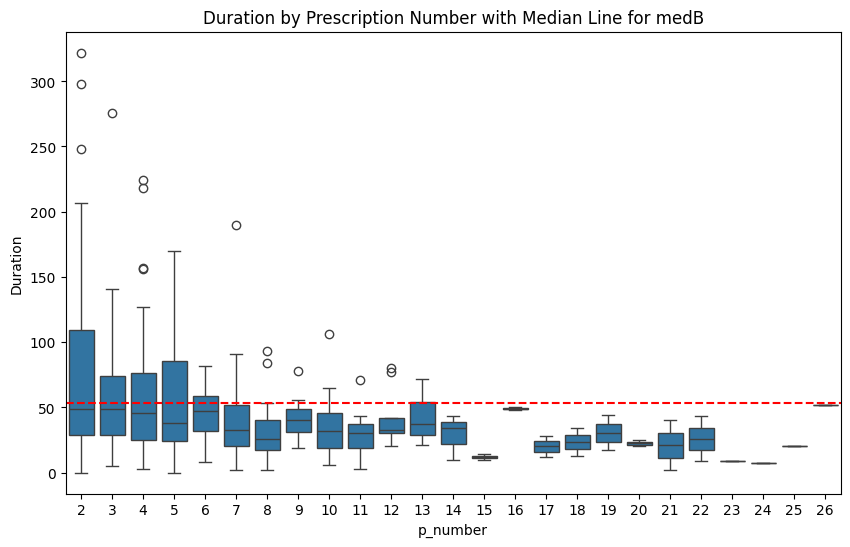

<module 'matplotlib.pyplot' from 'c:\\Users\\Andrew\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
medA = See('medA')
medB = See('medB')

see_assumption(medA, 'medA')
see_assumption(medB, 'medB')

Sessa Empirical Estimator using DBScan

In [43]:
def see_dbscan(arg1):
  C09CA01 = tidy_df[tidy_df['ATC'] == arg1]

  Drug_see_p0 = C09CA01.copy()
  Drug_see_p1 = C09CA01.copy()

  Drug_see_p1 = Drug_see_p1.sort_values(by=['pnr', 'eksd']).copy()
  Drug_see_p1['prev_eksd'] = Drug_see_p1.groupby('pnr')['eksd'].shift(1)
  Drug_see_p1 = Drug_see_p1.dropna(subset=['prev_eksd'])
  Drug_see_p1 = Drug_see_p1.groupby('pnr').filter(lambda x: len(x) > 1).sample(frac=1).drop_duplicates('pnr')
  Drug_see_p1['event_interval'] = (Drug_see_p1['eksd'] - Drug_see_p1['prev_eksd']).dt.days

  # Compute ECDF
  ecdf = Drug_see_p1['event_interval'].value_counts().sort_index().cumsum() / len(Drug_see_p1)
  dfper = pd.DataFrame({'x': ecdf.index, 'y': ecdf.values})
  dfper = dfper[dfper['y'] <= 0.8]
  ni = dfper['x'].max()

  plt.figure(figsize=(12, 6))
  plt.subplot(1, 2, 1)
  plt.scatter(dfper['x'], dfper['y'], label='80% ECDF for ' + arg1)
  plt.xlabel('Event Interval')
  plt.title(f'80% ECDF for {arg1}')
  plt.legend()
  plt.subplot(1, 2, 2)
  plt.scatter(ecdf.index, ecdf.values, label='100% ECDF for ' + arg1) 
  plt.xlabel('Event Interval')
  plt.title(f'100% ECDF for {arg1}')
  plt.legend()
  plt.show()

  Drug_see_p2 = Drug_see_p1[Drug_see_p1['event_interval'] <= ni]

  valid_intervals = Drug_see_p2['event_interval'].dropna()  # Remove NaNs
  valid_intervals = valid_intervals[valid_intervals > 0]    # Remove zeros or negatives

  density = gaussian_kde(np.log(valid_intervals))
  x = np.linspace(min(np.log(valid_intervals)), max(np.log(valid_intervals)), 1000)

  plt.plot(x, density(x))
  plt.title('Log(event interval)')
  plt.show()

  # Normalize data for DBSCAN
  scaled_data = StandardScaler().fit_transform(dfper[['x']])

  # Apply DBSCAN (Tune `eps` and `min_samples`)
  dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust `eps` and `min_samples` for better clustering
  dfper['cluster'] = dbscan.fit_predict(scaled_data)

  # Handle noise points (outliers labeled as -1)
  dfper.loc[dfper['cluster'] == -1, 'cluster'] = np.nan  # Mark outliers as NaN

  # Remove noise points (-1) and filter data properly
  filtered_data = dfper[dfper['cluster'].notna()]
  filtered_labels = filtered_data['cluster'].astype(int)

  # Correctly filter `scaled_data` using `.iloc`
  filtered_scaled_data = scaled_data[dfper['cluster'].notna(), :]

  # Ensure we have at least 2 clusters for silhouette score
  if len(set(filtered_labels)) > 1:
      score = silhouette_score(filtered_scaled_data, filtered_labels)
      print(f"Silhouette Score: {score}")
  else:
      print("Not enough clusters to compute silhouette score.")

  unique_clusters = dfper['cluster'].dropna().unique()
  colors = plt.cm.viridis(np.linspace(0, 1, len(unique_clusters)))

  # Plot ECDF with cluster
  for i, cluster in enumerate(unique_clusters):
    cluster_points = dfper[dfper['cluster'] == cluster]
    plt.scatter(cluster_points['x'], cluster_points['y'], color=colors[i], label=f'Cluster {int(cluster)}', alpha=0.7)

  if dfper['cluster'].isna().sum() > 0:
    noise_points = dfper[dfper['cluster'].isna()]
    plt.scatter(noise_points['x'], noise_points['y'], color='black', label='Noise', alpha=0.5, marker='x')

  plt.xlabel('Event Interval')
  plt.ylabel('Cumulative Probability')
  plt.title(f'Clustered ECDF for {arg1}')
  plt.legend()
  plt.show()

  # Compute cluster summary
  cluster_summary = dfper.groupby('cluster')['x'].agg(['min', 'max', 'median']).reset_index()

  # Merge clusters back
  Drug_see_p1['event_interval'] = Drug_see_p1['event_interval'].astype(float)
  results = Drug_see_p1.merge(cluster_summary, left_on='event_interval', right_on='median', how='left')
  results['cluster'] = results['cluster'].fillna(0).astype(int)
  results['Median'] = results['median'].apply(np.exp)
  results = results[['pnr', 'Median', 'cluster']]

  # Assign the most frequent cluster to missing values
  t1 = results['cluster'].value_counts().idxmax()
  t1_merged = results[results['cluster'] == t1].iloc[0]

  Drug_see_p1 = Drug_see_p1.merge(results, on='pnr', how='left')
  Drug_see_p1['Median'] = Drug_see_p1['Median'].fillna(t1_merged['Median'])
  Drug_see_p1['cluster'] = Drug_see_p1['cluster'].fillna(0).astype(int)
  Drug_see_p1['test'] = (Drug_see_p1['event_interval'] - Drug_see_p1['Median']).round(1)

  Drug_see_p3 = Drug_see_p1[['pnr', 'Median', 'cluster']]
  Drug_see_p0 = Drug_see_p0.merge(Drug_see_p3, on='pnr', how='left')
  Drug_see_p0['Median'] = Drug_see_p0['Median'].fillna(t1_merged['Median'])
  Drug_see_p0['cluster'] = Drug_see_p0['cluster'].fillna(0).astype(int)

  return Drug_see_p0

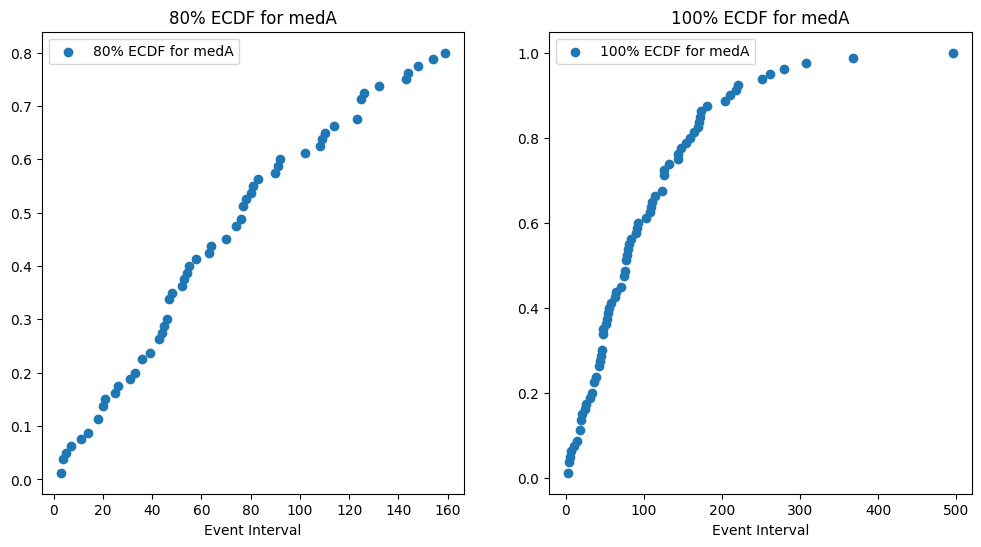

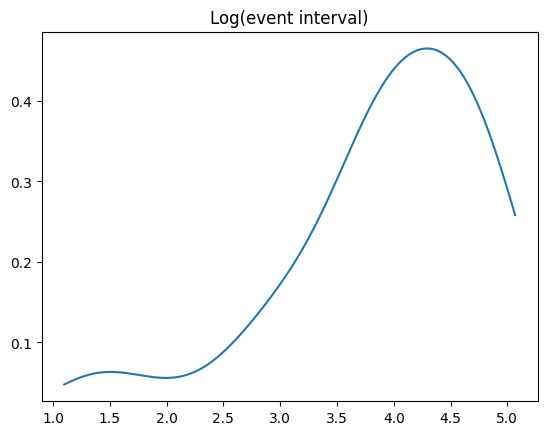

Not enough clusters to compute silhouette score.


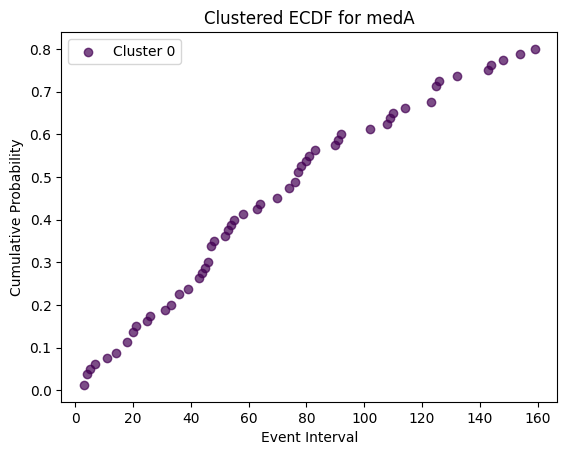

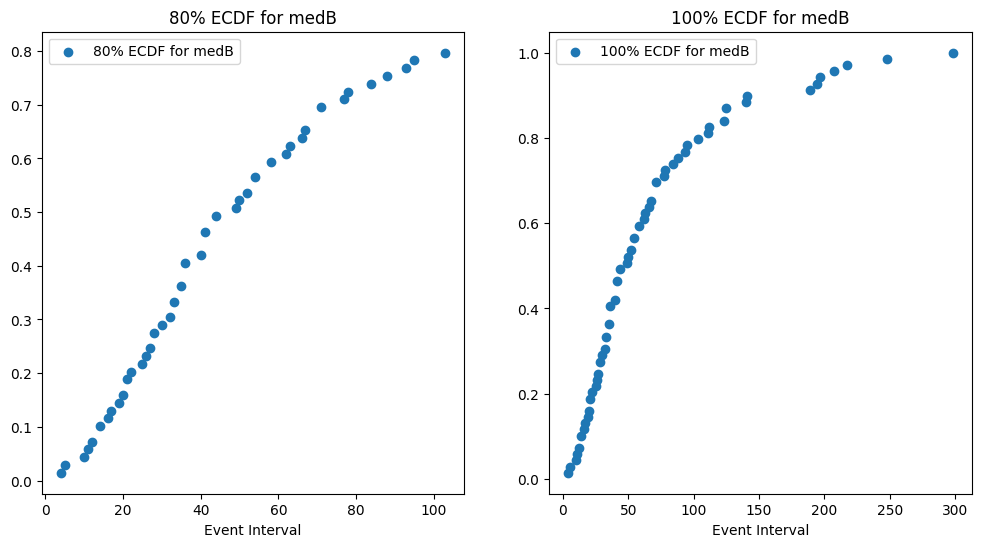

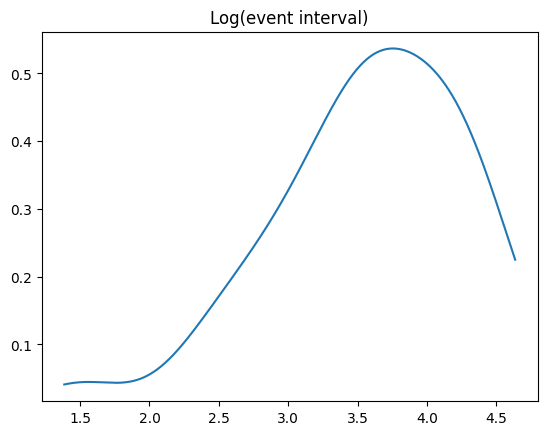

Not enough clusters to compute silhouette score.


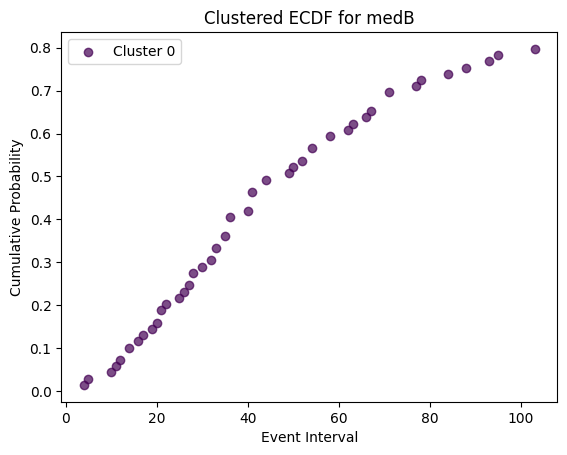

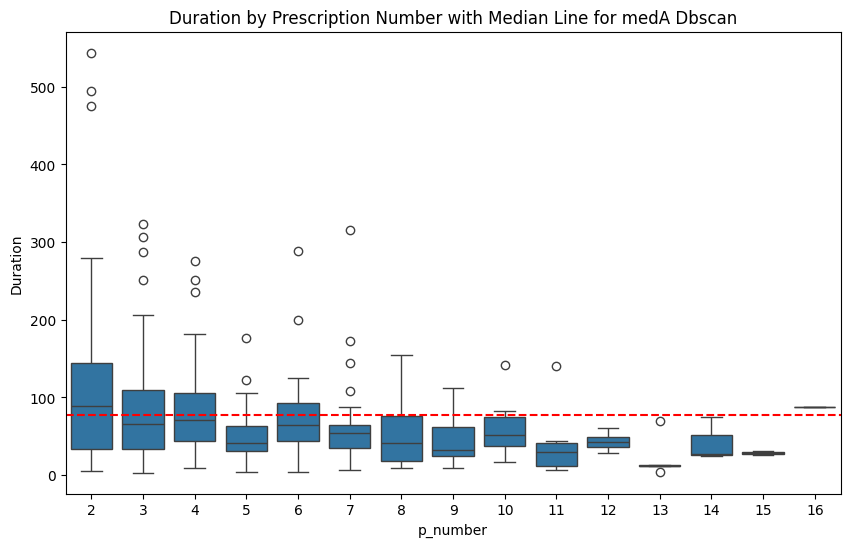

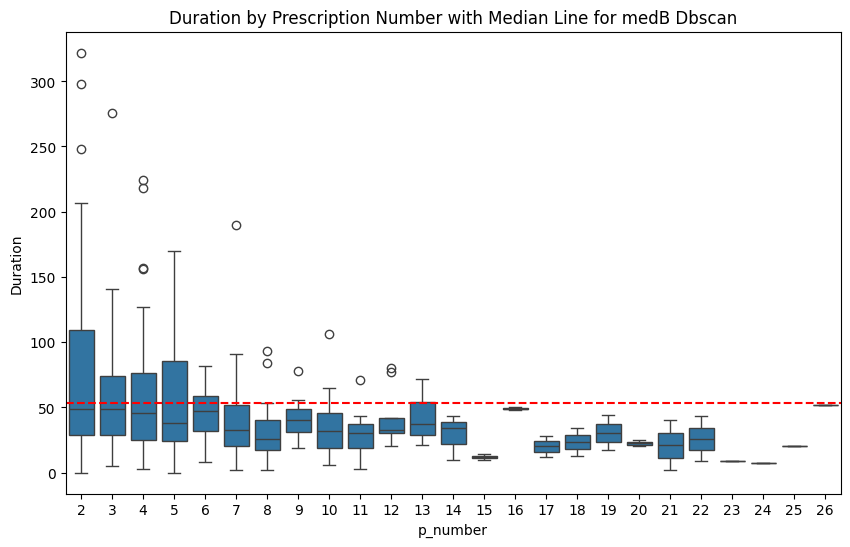

<module 'matplotlib.pyplot' from 'c:\\Users\\Andrew\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [46]:
medA_dbscan = see_dbscan('medA')
medB_dbscan = see_dbscan('medB')

see_assumption(medA_dbscan, 'medA Dbscan')
see_assumption(medB_dbscan, 'medB Dbscan')

In this analysis, we compare **KMeans** and **DBSCAN** clustering based on their performance in segmenting event intervals and understanding prescription duration trends.

---

## **KMeans Clustering Analysis**  

### **1. Clustering & ECDF Insights**  
- **KMeans effectively segments the data into two clusters**, as seen in the ECDF plots.  
- The 80% and 100% ECDF graphs for **medA** and **medB** show a **gradual, smooth transition** between event intervals, indicating that KMeans captures inherent patterns in the prescription data.  
- The clusters are relatively **well-separated**, meaning the chosen number of clusters (k=2) is meaningful in distinguishing different patterns in the event intervals.

### **2. Silhouette Score & Cluster Evaluation**  
- The silhouette score was used to determine the optimal number of clusters, and **K=2** resulted in the best separation.  
- Adding more clusters led to a **decline in silhouette score**, indicating that further segmentation **did not improve cluster quality**.
- This suggests that the event intervals naturally divide into two main groups rather than multiple distinct clusters.

### **3. Duration vs. Prescription Number (Boxplots)**  
- The **boxplots show a decreasing median duration** as prescription numbers increase.  
- **Key observations:**  
  - The first few prescriptions have **higher median durations and larger variance**, likely due to initial prescription adjustments.  
  - As the prescription count increases, the variance reduces, and the median stabilizes, **indicating better adherence or a stable treatment plan**.
- KMeans captures these variations well, providing a structured way to analyze the impact of prescription frequency on duration.

---

## **DBSCAN Clustering Analysis**  

### **1. Density-Based Clustering & ECDF Insights**  
- DBSCAN is a **density-based algorithm**, meaning it groups data points **based on density** rather than a predefined number of clusters.  
- **Findings:**  
  - DBSCAN **identified only one major cluster** and classified a few data points as **noise/outliers**.  
  - Unlike KMeans, DBSCAN **did not naturally form multiple clusters**, indicating that the data may not have distinct density variations.  
  - The **ECDF plots show a nearly continuous distribution**, which aligns with DBSCAN’s difficulty in identifying separate groups.

### **2. Silhouette Score Limitation**  
- The **silhouette score could not be computed**, as DBSCAN found only **one significant cluster**.  
- This indicates that the event intervals **do not have enough density-based separation** for DBSCAN to meaningfully form multiple clusters.  
- As a result, **DBSCAN fails to provide useful segmentation for this dataset**.

### **3. Duration vs. Prescription Number (Boxplots)**  
- The **boxplots under DBSCAN are similar to those in KMeans**, with **higher durations in the early prescriptions** and a downward trend over time.  
- However, since DBSCAN does not segment the data into multiple meaningful clusters, it does not provide **additional insights beyond outlier detection**.

---

## **Comparison: KMeans vs. DBSCAN**  

| **Feature**            | **KMeans**                            | **DBSCAN**                         |
|------------------------|--------------------------------------|------------------------------------|
| **Cluster Formation**  | Fixed number (2 clusters)           | Density-based (1 cluster + noise) |
| **Silhouette Score**   | Used to optimize cluster count      | Not applicable (single cluster)   |
| **Handling Outliers**  | Forces data into clusters           | Identifies and labels noise       |
| **Prescription Trends**| Decreasing duration trend observed  | Similar trend, slight variation   |
| **Best Use Case**      | When predefined clusters are needed | When data has varying densities   |
| **Weaknesses**        | Assumes clusters are spherical      | Struggles with evenly distributed data |

### **Additional Observations**
- **KMeans is better for structured clustering**, while **DBSCAN is more effective when clusters have varying densities**.  
- Since the dataset does not have **clear density-based clusters**, DBSCAN was **unable to segment the data meaningfully**.  
- If the dataset contained **dense clusters surrounded by sparse noise points**, DBSCAN would likely be more useful.

---

## **Conclusion**
1. **KMeans is the better approach for this dataset**, as it successfully identified two clusters and provided meaningful segmentation.  
2. **DBSCAN was not effective in clustering**, since the dataset lacks clear density variations.  
3. **For event interval classification, KMeans provides structured and interpretable results**, while DBSCAN is limited to identifying outliers rather than segmenting patterns.  
4. If **outlier detection** is important, DBSCAN could still be used, but for **prescription duration analysis and event clustering**, KMeans is more appropriate.  